- Reference <br>
https://www.kaggle.com/szuzhangzhi/vision-transformer-vit-cuda-as-usual/

I made a notebook by dividing it into [Train] and [Inference] parts by referring to the original notebook.

### Please upvote original notebook :)

In [1]:
import sys

package_path = '../input/vision-transformer-pytorch/VisionTransformer-Pytorch'
sys.path.append(package_path)

## Library

In [2]:
import os
import pandas as pd
import albumentations as albu
import matplotlib.pyplot as plt
import json
import seaborn as sns
import cv2
import albumentations as albu
import numpy as np

import time
import datetime
import copy

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split
from albumentations.pytorch import ToTensorV2

In [3]:
BASE_DIR="../input/cassava-leaf-disease-classification/"
TRAIN_IMAGES_DIR = os.path.join(BASE_DIR,'train_images')

train_df=pd.read_csv(os.path.join(BASE_DIR,'train.csv'))
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
print("Count of training images {0}".format(len(os.listdir(TRAIN_IMAGES_DIR))))

Count of training images 21397


In [5]:
with open(f'{BASE_DIR}/label_num_to_disease_map.json', 'r') as f:
    name_mapping = json.load(f)
    
name_mapping = {int(k): v for k, v in name_mapping.items()}
train_df['class_id'] = train_df['label'].map(name_mapping)

In [6]:
name_mapping

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

## Visualization

In [7]:
def visualize_images(image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for idx, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, idx+1)
        
        img = cv2.imread(os.path.join(TRAIN_IMAGES_DIR, image_id))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        
        plt.axis("off")
    
    plt.show()
        
        
def plot_augmentation(image_id, transform):
    plt.figure(figsize=(16, 4))
    
    img = cv2.imread(os.path.join(TRAIN_IMAGES_DIR, image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subploT(1, 3, 1)
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    x = transform(image=img)['image']
    plt.imshow(x)
    plt.aixs('off')
    
    plt.subplot(1, 3, 3)
    x = transform(image=img)['image']
    plt.imshow(x)
    plt.axis('off')
    
    plt.show()
    
    
def visualize(images, transform):
    '''
    Plot images and their transforms
    '''
    fig = plt.figure(figsize=(32, 16))
    
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plt.imshow(im)
        
    for i, im in enumreate(images):
        ax = fig.add_subplot(2, 5, i+6, xticks=[], yticks=[])
        plt.imshow(transform(image=im)['image'])

## Modeling

In [8]:
# CUSTOM DATASET CLASS
class CassavaDataset(Dataset):
    def __init__(
        self, df:pd.DataFrame, imfolder:str, train:bool=True, transforms=None
    ):
        self.df = df
        self.imfolder = imfolder
        self.train = train
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_id'])
        x = cv2.imread(im_path, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        
        if (self.transforms):
            x = self.transforms(image=x)['image']
            
        if (self.train):
            y = self.df.iloc[index]['label']
            return x, y
        else:
            return x

In [9]:
# AUGMENTATIONS
train_augs = albu.Compose([
    albu.RandomResizedCrop(height=384, width=384, p=1.0),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.ShiftScaleRotate(p=0.5),
    albu.Normalize(    
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],),
    ToTensorV2(),
])

valid_augs = albu.Compose([
    albu.Resize(height=384, width=384, p=1.0),
    albu.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],),
    ToTensorV2(),
])

In [10]:
# DATA SPLIT
train, valid = train_test_split(
    train_df,
    test_size=0.1,
    random_state=42,
    stratify=train_df.label.values
)

# RESET INDEX ON BOTH DATAFRAMES
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

train_targets = train.label.values

# TARGETS FOR VALIDATION
valid_targets = valid.label.values

In [11]:
# DEFINE PYTORCH CUSTOM DATASET
train_dataset = CassavaDataset(
    df = train,
    imfolder = TRAIN_IMAGES_DIR,
    train = True,
    transforms = train_augs
)

valid_dataset = CassavaDataset(
    df = valid,
    imfolder = TRAIN_IMAGES_DIR,
    train = True,
    transforms = valid_augs
)

In [12]:
def plot_image(img_dict):
    image_tensor = img_dict[0]
#     print(type(image_tensor))
    target = img_dict[1]
    print(target)
    plt.figure(figsize=(10, 10))
    image = image_tensor.permute(1, 2, 0)
#     print(image)
    plt.imshow(image)

1


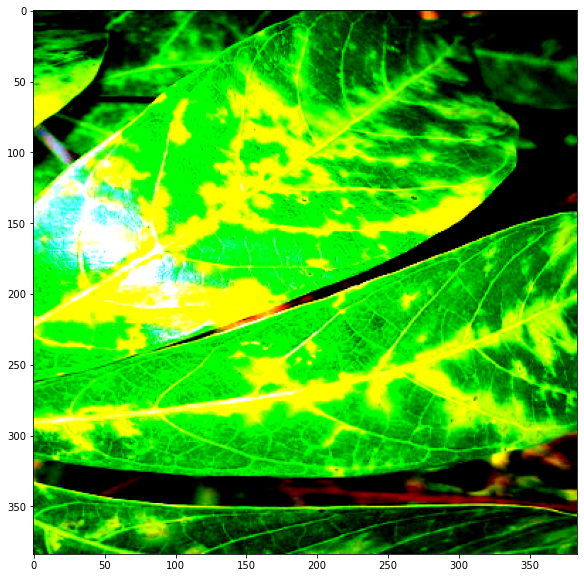

In [13]:
plot_image(train_dataset[5])

In [14]:
# MAKE PYTORCH DATALOADER
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    num_workers=4,
    shuffle=True,
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=16,
    num_workers=4,
    shuffle=False,
)

In [15]:
# TRAIN
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in rnage(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)
        
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero out the grads
                optimizer.zero_grad()
                
                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model = model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = crtiterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))
            
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    
    return model
    

In [16]:
from vision_transformer_pytorch import VisionTransformer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

datasets = {'train': train_dataset,
            'valid': valid_dataset}

dataloaders = {'train': train_loader,
               'valid': valid_loader}

model = VisionTransformer.from_name('ViT-B_16', num_classes=5)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
criterion = nn.CrossEntropyLoss()
num_epochs = 6

In [17]:
# LOAD MODEL
model.load_state_dict(torch.load('../input/cassava-vit-cuda-train/vit_b-16.pt'))

<All keys matched successfully>

## Submission

In [18]:
test_df = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')
image_path = '../input/cassava-leaf-disease-classification/test_images/'
# fake targets
test_targets = test_df.label.values

test_aug = albu.Compose([
    albu.CenterCrop(512, 512, p=1.),
    albu.Resize(384, 384),
    albu.Normalize(
         mean=[0.485, 0.456, 0.406], 
         std=[0.229, 0.224, 0.225], 
         max_pixel_value=255.0, 
         p=1.0),
    ToTensorV2()], p=1.)

test_dataset = CassavaDataset(
    df = test_df,
    imfolder = image_path,
    train = False,
    transforms = test_aug
)

test_loader = DataLoader(
    test_dataset,
    batch_size = 4,
    num_workers = 4,
    shuffle = False
)

In [19]:
predictions = []

for imgs in test_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
        model = model.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        predicted = predicted.to('cpu')
        predictions.append(predicted)

In [20]:
test_df['label'] = np.concatenate(predictions)

In [21]:
test_df.to_csv('submission.csv', index=False)

## Train: https://www.kaggle.com/nevret93/cassava-vit-cuda-train